In [1]:
import torch
import os,sys,yaml
from dotmap import DotMap
from einops import rearrange, reduce
import matplotlib.pyplot as plt
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from run import load_model

In [2]:
with open('/home/neoncloud/low_light/test/arid_confusion.yaml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg = DotMap(cfg)
model_, optimizer, lr_scheduler, start_epoch, train_dataloader, validate_dataloader, num_text_aug, text_tokenized, all_text_features = load_model(cfg)
model = model_.cuda()

img transformer layers: 12
loading clip pretrained model!
The following sub-module is not loaded
<All keys matched successfully>


In [3]:
model.eval()
with torch.no_grad():
    all_class_features = rearrange(all_text_features, 'c n d -> (c n) d')
    num = 0
    corr_1 = 0.0
    corr_5 = 0.0
    for data in validate_dataloader:
        print(data['frames'].shape)
        b, t, c, h, w = data['frames'].size()
        label = data['label'].cuda().unsqueeze(-1)
        text_features, video_features, class_features, motion_features = model.test(
             data['frames'].cuda(), text_features=all_class_features)
        # text_features, video_features, class_features, motion_features = model.test(
        #     data['frames'].cuda(), text_features=all_class_features)
    print(data['label'])

torch.Size([10, 32, 3, 224, 224])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


/home/neoncloud/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [4]:
print(video_features.shape)
video2text = (100.0 * video_features @ text_features.T).softmax(dim=-1)
video2text = reduce(
    video2text, 'b (n d) -> b d', 'mean',n=num_text_aug).cpu().numpy()
# video2text = video2text.mean(dim=1, keepdim=False).cpu().numpy()
print(video2text.shape)

torch.Size([10, 512])
(10, 10)


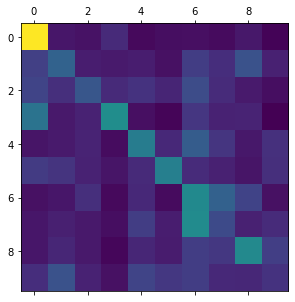

In [5]:
plt.matshow(video2text)

In [6]:
image2text = (100.0 * class_features @ text_features.T).mean(0).softmax(dim=-1)
print(image2text.shape)
image2text = reduce(
    image2text, 'b (n d) -> b d', 'mean',n=num_text_aug).cpu().numpy()

torch.Size([10, 160])


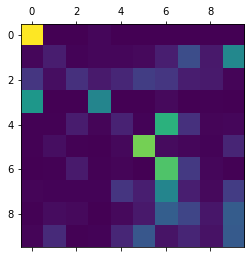

In [7]:
plt.matshow(image2text)

In [8]:
motion2text = (100.0 * motion_features @ text_features.T).mean(0).softmax(dim=-1)
print(motion2text.shape)
motion2text = reduce(
    motion2text, 'd1 (n d2) -> d1 d2', 'mean',n=num_text_aug).cpu().numpy()

torch.Size([10, 160])


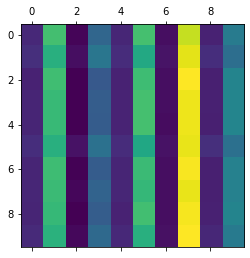

In [9]:
plt.matshow(motion2text)

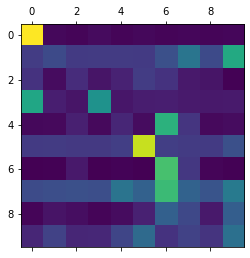

In [11]:
plt.matshow(image2text+motion2text.T)